In [1]:
import numpy as np
import h5py
import numpy as np
from scipy.integrate import solve_ivp
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import torch
import matplotlib.pyplot as plt

In [2]:
psi = np.load('/home/fabio/work/HM_and_AI_models/VAE_Model/combined_shuffled.npy')

print(psi.shape)

psi_one = psi[:, 0, :]  
print(psi_one.shape)
# # psi_one = psi_one[:, :]

psi_two = psi[:, 1, :]
# # psi_two  = psi_two[:, :]

psi = np.concatenate((psi_one, psi_two), axis=0)

print(psi.shape)

(557252, 2, 75)
(557252, 75)
(1114504, 75)


In [3]:
# Pre-processing

lead = 1

trainN = 200000
valN = 50000
index = 63


print(psi.shape)
mean_psi = np.mean(psi, axis=0, keepdims=True)
std_psi = np.std(psi, axis=0, keepdims=True)
psi = (psi - mean_psi) / std_psi



psi_train_input = torch.tensor(psi[1:trainN + 1,:])
psi_train_label =  torch.tensor(psi[1 + lead:trainN+lead + 1,:])
###Changed to include prior state
psi_memory = torch.tensor(psi[0:trainN, :])

psi_val_input = torch.tensor(psi[trainN + 5: trainN + valN + 5,:])
psi_val_label =  torch.tensor(psi[trainN + lead + 5 : trainN + valN + lead + 5,:])
### Same as above
psi_memory_val = torch.tensor(psi[trainN + 4 : trainN + valN + 4, :])

print(psi_train_input.shape)
print(psi_train_label.shape)
print(psi_val_input.shape)
print(psi_val_label.shape)
print(psi_memory.shape)

#Total Variation Integral
def total_variation_distance(p,q):
	p = np.array(p)
	q = np.array(q)
	return 0.5 * np.sum(np.abs(p-q))

# #actual implementation
# pred_hist, _ = np.histogram(predictions, bins=50, density=True)
# actual_hist, _ = np.histogram(actual_values,bins=50,density=True)

# tvd = total_variation_distance(pred_hist,actual_hist)


(1114504, 75)
torch.Size([200000, 75])
torch.Size([200000, 75])
torch.Size([50000, 75])
torch.Size([50000, 75])
torch.Size([200000, 75])


(1114504, 75)


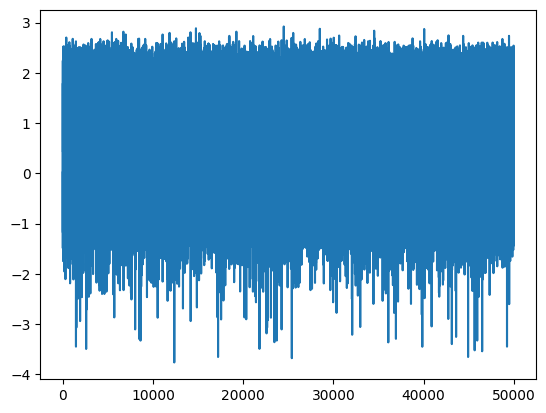

In [4]:
print(psi.shape)
# plt.plot(psi_train_input[0:200000,63])
plt.plot(psi_val_input[0:200000,63])


In [5]:
# Define the encoder (MLP)
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(75, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_mu = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Latent space (2)
        self.fc_logvar = nn.Linear(512, latent_dim)  # Hidden layer (128) -> Log variance (2)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for hidden layer
        x = torch.relu(self.fc2(x)) + x
        x = torch.relu(self.fc3(x)) + x
        x = torch.relu(self.fc4(x)) + x
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define the decoder (MLP)
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, condition_dim, prev_elem):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + condition_dim + prev_elem, 512)  # Input layer (2 + 2) -> Hidden layer (128)
        self.fc2 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc3 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc4 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc5 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc6 = nn.Linear(512, 512)  # Hidden layer (128) -> Hidden layer (128)
        self.fc_output = nn.Linear(512, output_dim)  # Hidden layer (128) -> Output layer (2)

    def forward(self, z, condition, prev_element):
        z = torch.cat((z, condition), dim=1)  # Concatenate latent vector and condition 
        z = torch.cat((z, prev_element), dim = 1)
        z = torch.relu(self.fc1(z))  # Activation function for hidden layer
        z = torch.relu(self.fc2(z)) + z
        z = torch.relu(self.fc3(z)) + z
        z = torch.relu(self.fc4(z)) + z
        output = self.fc_output(z)
        return output

# Define the VAE model
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, output_dim, condition_dim, prev_elem):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, output_dim, condition_dim, prev_elem)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
#I need to put the prev_elem (X(t - 1)) in the latent space that is passed to 
#the decoder to recontruct an output (X(t + 1)).
    def decode(self, z, condition, prev_elem):
        return self.decoder(z, condition, prev_elem)

    def forward(self, x, condition, prev_elem):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, condition, prev_elem)
        return output, mu, logvar


Epoch 1, 
          Reconstrunction Loss: 13497.77734375,
          KL Divergence Lwss: 996.0792846679688

          Validation Reconstrunction Loss: 36204.03125,
          Validation KL Divergence Loss: 2991.18896484375
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


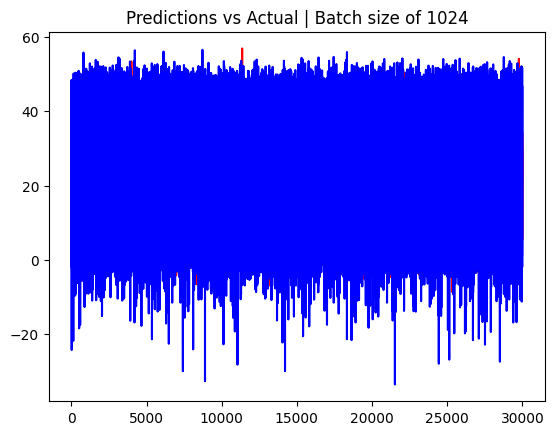

Epoch 2, 
          Reconstrunction Loss: 12931.56640625,
          KL Divergence Lwss: 718.1515502929688

          Validation Reconstrunction Loss: 34370.921875,
          Validation KL Divergence Loss: 2223.057373046875
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


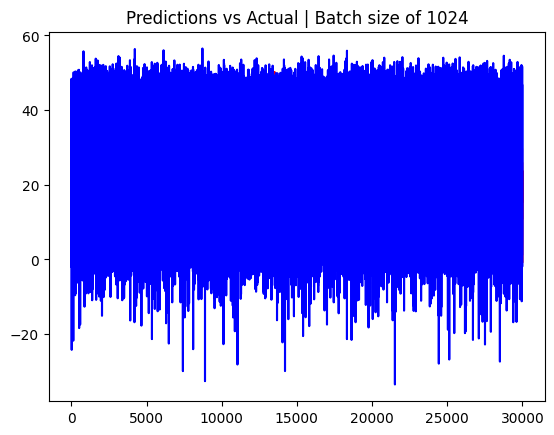

Epoch 3, 
          Reconstrunction Loss: 12072.169921875,
          KL Divergence Lwss: 627.0857543945312

          Validation Reconstrunction Loss: 34271.7265625,
          Validation KL Divergence Loss: 1957.3419189453125
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


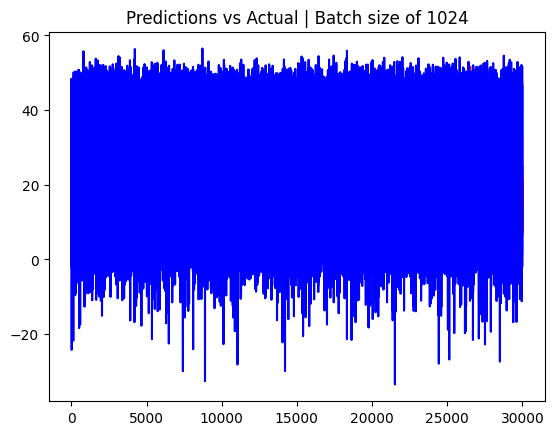

Epoch 4, 
          Reconstrunction Loss: 11646.859375,
          KL Divergence Lwss: 576.3140869140625

          Validation Reconstrunction Loss: 34165.16796875,
          Validation KL Divergence Loss: 1809.5201416015625
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


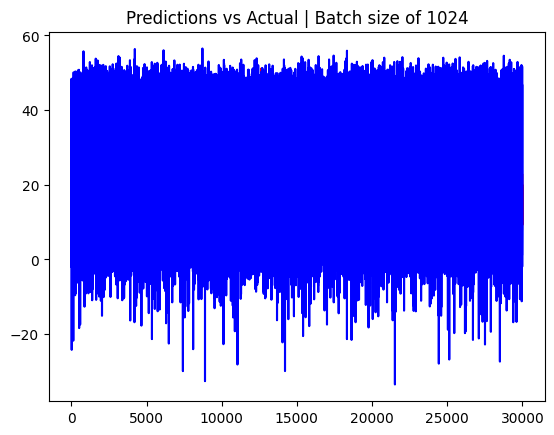

Epoch 5, 
          Reconstrunction Loss: 11433.275390625,
          KL Divergence Lwss: 560.9120483398438

          Validation Reconstrunction Loss: 32725.498046875,
          Validation KL Divergence Loss: 1747.143798828125
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


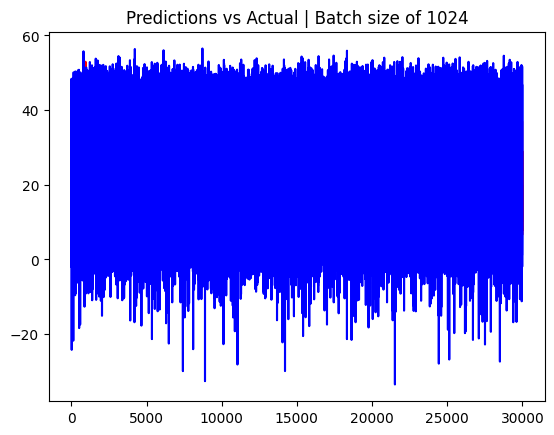

Epoch 6, 
          Reconstrunction Loss: 11171.3701171875,
          KL Divergence Lwss: 552.74853515625

          Validation Reconstrunction Loss: 32014.84765625,
          Validation KL Divergence Loss: 1749.2779541015625
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


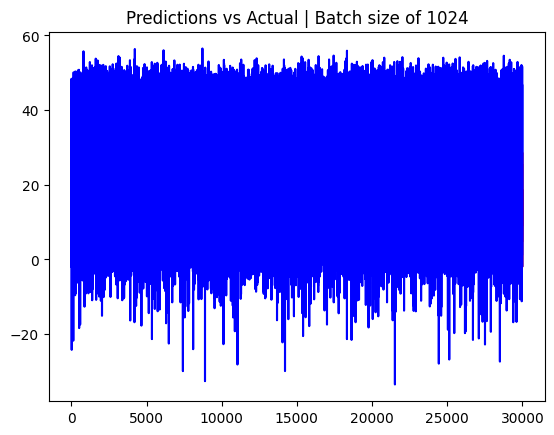

Epoch 7, 
          Reconstrunction Loss: 11046.138671875,
          KL Divergence Lwss: 539.4696655273438

          Validation Reconstrunction Loss: 30555.2734375,
          Validation KL Divergence Loss: 1700.869140625
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


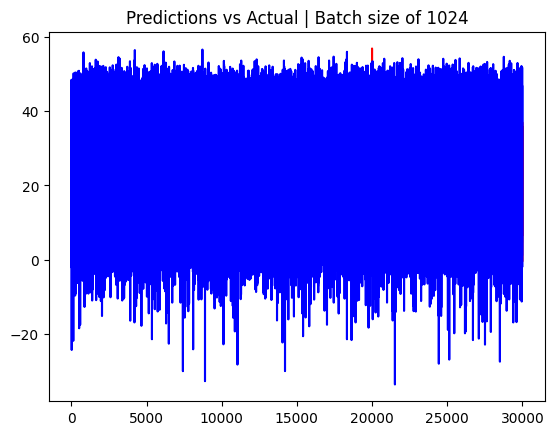

Epoch 8, 
          Reconstrunction Loss: 11265.2412109375,
          KL Divergence Lwss: 535.9609375

          Validation Reconstrunction Loss: 30706.650390625,
          Validation KL Divergence Loss: 1687.169921875
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


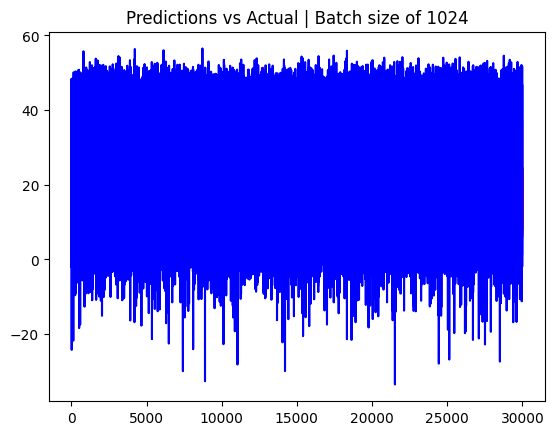

Epoch 9, 
          Reconstrunction Loss: 10351.921875,
          KL Divergence Lwss: 520.2274169921875

          Validation Reconstrunction Loss: 31702.986328125,
          Validation KL Divergence Loss: 1624.422607421875
[13.94058271]
tensor([10.6942, 22.9701, 24.6052,  ...,  2.9926, 28.4037, 46.5827],
       dtype=torch.float64)


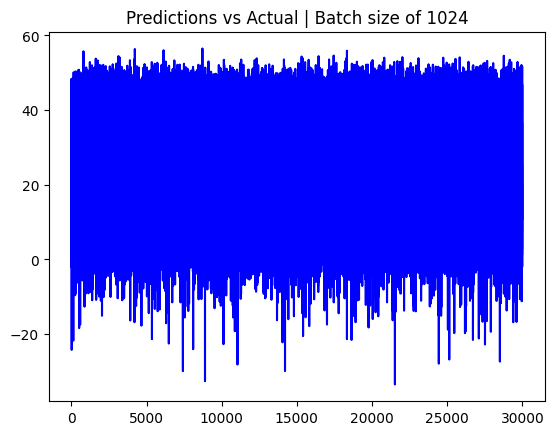

Epoch 10, 
          Reconstrunction Loss: 10997.564453125,
          KL Divergence Lwss: 516.5808715820312

          Validation Reconstrunction Loss: 30267.45703125,
          Validation KL Divergence Loss: 1629.769287109375


KeyboardInterrupt: 

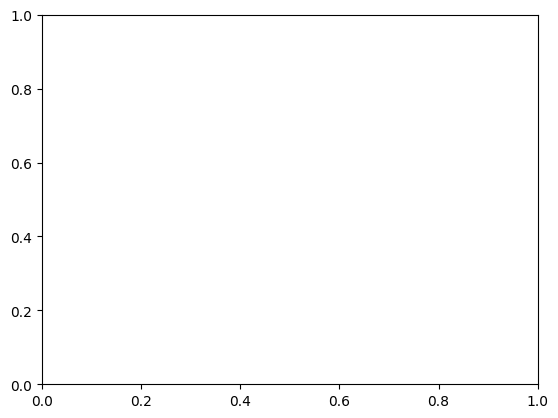

In [6]:


input_dim = 1
output_dim = 75
latent_dim = 1024
condition_dim = 75
batch_size = 1024
num_epochs = 50
prev_elem = 75

# Initialize the model, optimizer, and loss function
model = ConditionalVAE(input_dim, latent_dim, output_dim, condition_dim, prev_elem)
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(num_epochs):
    model.train()
    for batch in range (2, trainN, batch_size):

        ### Changed here to include the previous element in batching samples
        prev_element = psi_memory[batch:batch + batch_size,:]


        input_batch = psi_train_input[batch:batch + batch_size,:]
        label_batch = psi_train_label[batch:batch + batch_size,:]
        optimizer.zero_grad()


        ### Changed here to pass the previous element to the Decoder to reconstruct using the previous states  ###
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())

        # Reconstruction loss
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        # KL divergence loss
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        
        # Total loss
        loss = reconstruction_loss + 10 * kl_loss

        loss.backward()
        optimizer.step()

    print(f'''Epoch {epoch+1}, 
          Reconstrunction Loss: {reconstruction_loss},
          KL Divergence Lwss: {kl_loss}''')

    # Validation Loss
    for batch in range (0, valN, batch_size):
        
        ### Same as before but for the validiation set ###
        prev_element = psi_memory_val[batch:batch + batch_size,:]

        input_batch = psi_val_input[batch:batch + batch_size,:]
        label_batch = psi_val_label[batch:batch + batch_size,:]
        
        ### Same as before but for the validation set ### 
        output, mu, logvar = model(label_batch.float().cuda(), input_batch.float().cuda(), prev_element.float().cuda())
        reconstruction_loss = F.mse_loss(output, label_batch.float().cuda(), reduction="sum")
        kl_loss = 0.5 * (mu ** 2 + torch.exp(logvar) - 1 - logvar).sum()
        val_loss = reconstruction_loss + 10 * kl_loss # Experiment HIGHER coefficients
        # Print both reconstruction_loss and kl_loss

    print(f'''
          Validation Reconstrunction Loss: {reconstruction_loss},
          Validation KL Divergence Loss: {kl_loss}''')

    # Inference

    ### Changed here to use the x(t) and x(t - 1) as ground truth elements
    initial_cond = torch.reshape(torch.tensor(psi[1,:]), [1, 75])
    preveious_elem = torch.reshape(torch.tensor(psi[0,:]), [1, 75])

    time_step = 30000
    z = torch.zeros([1,latent_dim])
    num_ens = 1
    pred = np.zeros ([time_step, 75, num_ens])

    for k in range (0, time_step):

        for ens in range (0, num_ens):
            if (k ==0):
                z = torch.randn_like(z)

                ### Change here passes the X(t - 1) to the initial condition
                y = (model.decode(z.float().cuda(), initial_cond.float().cuda(), preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:,ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                preveious_elem = initial_cond
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])

            else:
                select_ens = np.random.randint(0,num_ens,1)
                z = torch.randn_like(z)
                ### Change here same as above
                input_element = torch.reshape(torch.tensor(pred[k-1,:,select_ens]), [1,75]).float().cuda()

                y = (model.decode(z.float().cuda(), input_element, preveious_elem.float().cuda())).detach().cpu().numpy()
                pred[k,:, ens] = y
                y_denorm = (y * std_psi[:, :] + mean_psi[:, :])
                preveious_elem = initial_cond
                initial_cond = torch.tensor((y_denorm - mean_psi[:, :]) / std_psi[:, :])
                ### Change here to use X(t - 1) as previous element in next pred


    # Denormalize final preds
    print(std_psi[:, 63])
    pred_mean = pred * std_psi[:, 63] + mean_psi[:, 63]

    # Denormalize test labels
    actual_values = psi_train_label[:time_step, 63] * std_psi[:, 63] + mean_psi[:, 63]
    print(actual_values)

    plt.plot(pred_mean[0:30000,63],'r')
    plt.plot(actual_values[0:30000],'b')
    plt.title(f"Predictions vs Actual | Batch size of {batch_size}")
    plt.show()
    plt.cla()